# Final Project - Introduction to Machine Learning

Author: Maedeh Lavvaf, March 7, 2022

## Introduction

This Jupiter Notebook will be creating a machine learning model and will use the "Cheese" Dataset. This dataset is can originally be found on the Government of Canada's Open Government Portal, but has been modified by the course instructors for use in this project.


### Question of Interest


I will use this data set to create a predictive model that will predict the Manufacturing type of our cheese. The positive label in this data is artisan. I would like to ask this question because I am interested to see if a specific type of milk is more commonly used in artisan cheeses. This is a classfication problem and I will use a Support Vector Metric classifier to create my model.

### Dataset Description

This dataset contain the following columns:

- CheeseId
- ManufacturerProvCode
- ManufacturingTypeEn
- MoisturePercent
- FlavourEn
- CharacteristicsEn
- Organic
- CategoryTypeEn
- MilkTypeEn
- MilkTreatmentTypeEn
- RindTypeEn
- CheeseName
- FatLevel

### Exploratory Data Analysis

Let's start by looking at our data.

In [1]:
##Import relevant libraries
import altair as alt
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    StandardScaler,
    normalize,
    scale)
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.svm import SVC, SVR
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


In [2]:
#Import and split the date
cheese_df = pd.read_csv('data/cheese_data.csv')
train_df, test_df = train_test_split(cheese_df, test_size= 0.2, random_state=123)
train_df.head(5)

,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
482,1506,QC,Artisan,48.0,"Sharp, hazelnutty","Pressed, surface-ripened",0,Semi-soft Cheese,Cow,Pasteurized,Washed Rind,Raclette Griffon,lower fat
896,2055,QC,Artisan,45.0,NaN,NaN,0,Veined Cheeses,Cow,Pasteurized,NaN,Rébellion 1837,higher fat
421,1445,QC,Industrial,50.0,Mild,NaN,0,Soft Cheese,Cow,Pasteurized,Bloomy Rind,Mini-Brie,lower fat
929,2141,BC,Artisan,40.0,NaN,NaN,0,Semi-soft Cheese,Cow,Pasteurized,No Rind,Aged Farmhouse,higher fat
737,1810,QC,Artisan,65.0,Acidulous,"Crumbly and soft texture, whitish",0,Fresh Cheese,Cow,Pasteurized,No Rind,Ricotta (l'Ancêtre),lower fat


In [3]:
#use describe on data
train_df.describe(include='all')

,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
count,833.000000,833,833,821.000000,637,522,833.000000,813,832,781,579,833,833
unique,NaN,10,3,NaN,515,446,NaN,6,8,3,4,830,2
top,NaN,QC,Industrial,NaN,Mild,Creamy,NaN,Firm Cheese,Cow,Pasteurized,No Rind,Boerenkaas,lower fat
freq,NaN,635,370,NaN,48,12,NaN,271,596,648,329,2,548
mean,1563.432173,NaN,NaN,47.052741,NaN,NaN,0.091236,NaN,NaN,NaN,NaN,NaN,NaN
std,445.350681,NaN,NaN,9.660351,NaN,NaN,0.288118,NaN,NaN,NaN,NaN,NaN,NaN
min,228.000000,NaN,NaN,12.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1290.000000,NaN,NaN,40.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1554.000000,NaN,NaN,46.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,1897.000000,NaN,NaN,52.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


I wanted to take a closer look at our data and see if there is anything interesting or out of the ordinary that jumps out. Since Manufacturing Type is our target, I can use this to confirm that there are three unique categories.

Of note, the Milk Treatment Type column is also three categories, so I think that it will be fitting to use to answer the question once I have built the model.

Otherwise, I can see that the most common type of cheese in our test data is mild, creamy, pasturized, firm, lower fat, cow cheese, manufactured in an industrial setting in Quebec.

In [4]:
#look for null and dtypes
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833 entries, 482 to 1041
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CheeseId              833 non-null    int64  
 1   ManufacturerProvCode  833 non-null    object 
 2   ManufacturingTypeEn   833 non-null    object 
 3   MoisturePercent       821 non-null    float64
 4   FlavourEn             637 non-null    object 
 5   CharacteristicsEn     522 non-null    object 
 6   Organic               833 non-null    int64  
 7   CategoryTypeEn        813 non-null    object 
 8   MilkTypeEn            832 non-null    object 
 9   MilkTreatmentTypeEn   781 non-null    object 
 10  RindTypeEn            579 non-null    object 
 11  CheeseName            833 non-null    object 
 12  FatLevel              833 non-null    object 
dtypes: float64(1), int64(2), object(10)
memory usage: 91.1+ KB


Although columns with some null values are OK and can be corrected as we work our model using SimpleImputer, I do not want to use columns with too many null values in this model. Therefore, I will drop FlavorEn, CharacteristicsEN and RindType for this reason. I will also be dropping CheeseID as I don't think it will be useful. Although our MilkTreatmentType column contains more null values than I would like, it is less than 10% and therefore I will be keeping it, as I think it would be particularly relevant in our model.

In [5]:
#Drop columns that will not be useful and define our target
X_train, y_train = train_df.drop(columns=['FlavourEn','CharacteristicsEn', 'RindTypeEn','CheeseId', 'ManufacturingTypeEn']), train_df['ManufacturingTypeEn']
X_test, y_test = test_df.drop(columns=['FlavourEn','CharacteristicsEn', 'RindTypeEn','CheeseId', 'ManufacturingTypeEn']), test_df['ManufacturingTypeEn']
X_train.head(5)

,ManufacturerProvCode,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,CheeseName,FatLevel
482,QC,48.0,0,Semi-soft Cheese,Cow,Pasteurized,Raclette Griffon,lower fat
896,QC,45.0,0,Veined Cheeses,Cow,Pasteurized,Rébellion 1837,higher fat
421,QC,50.0,0,Soft Cheese,Cow,Pasteurized,Mini-Brie,lower fat
929,BC,40.0,0,Semi-soft Cheese,Cow,Pasteurized,Aged Farmhouse,higher fat
737,QC,65.0,0,Fresh Cheese,Cow,Pasteurized,Ricotta (l'Ancêtre),lower fat


Before building the model, I think it would be interesting to explore our data using some visualizations. I would like to start by looking at the distribution of our target column, to see if the data is balanced.

In [6]:
#plot to determine distribution of target
manf_df = pd.DataFrame(y_train)
manf_type_plot = alt.Chart(manf_df, width=500, height=300). mark_bar().encode(
    x=alt.X('ManufacturingTypeEn', title= "Manufacturing Type"),
    y='count():Q'
    ).properties(title='Chart 1: Distribution of Target')

manf_type_plot

alt.Chart(...)

As we can see from our plot, our class is not totally balanced. This is something to keep in mind when deciding which model is best later on in this analysis.

Next, I would like to plot the distribution of milk treatment type. I'd like to see if this is similar to our manufacturing type distribution.

In [7]:
#plot to determine distribution of milk type
milk_type_plot = alt.Chart(X_train, height=300, width=500).mark_bar().encode(
    x= alt.X("MilkTreatmentTypeEn:N", title="Milk Treatment Type"),
    y="count():Q"
    ).properties(title= "Chart 2: Distribution of Milk Treatment Type")
milk_type_plot

alt.Chart(...)

## Methods and Results

Now that I have a better idea of what my data looks like and what information I'd like to use in my model, I would like to separate them by category to make them easier to think about in terms of my model.

**X_train:**

Numeric: MoisturePercent

Categorical: ManufacturerProvCode, MilkTypeEn, MilkTreatmentTypeEn

Text: CheeseName

Binary: Organic, FatLevel

**y_train/target:** ManufacturingTypeEn (categorical)


Now, we can start on our machine learning model.
The first thing I would like to do is create a baseline model to which we can compare our analysis using DummyClassifier. I will use the data I already separated above.

In [8]:
#create baseline model
dummy= DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.44417767106842737

Our baseline score is not very good.
The next step will be to transform our data using pipelines so that we can test a few models and see which one is best before tuning our hyperparameters. As seen above, our data has four categories. Here is what I will do for each category.

Numeric: This column does not need to be scaled, but it does have missing values, so I will use SimpleImputer on it.

Categorical: These columns need to be transformed using OneHotEncoder and SimpleImputer to correct missing values.

Text: I will transform this using CountVectorizer

Binary: I will use OneHotEncoder here as well, but set drop to "if_binary" to avoid duplicate columns. There are no missing values in these columns.
First, I want to try KNighborsClassifer

In [9]:
#seperate features into categories
num_feats = ["MoisturePercent"]
cat_feats = ['ManufacturerProvCode', 'MilkTypeEn', 'MilkTreatmentTypeEn']
binary_feats = ['Organic', 'FatLevel']
text_feats = 'CheeseName'

#make pipelines to transform
num_trans =make_pipeline(SimpleImputer(strategy ='median'))
cat_trans = make_pipeline(SimpleImputer(strategy ='most_frequent', fill_value="missing"),
                         OneHotEncoder(handle_unknown = 'ignore'))
binary_trans = make_pipeline(OneHotEncoder(drop='if_binary',dtype='int', sparse=False))
text_trans = make_pipeline(CountVectorizer())
#make preprocessor
preprocessor = make_column_transformer((num_trans, num_feats),
                                      (cat_trans, cat_feats),
                                      (binary_trans, binary_feats),
                                    (text_trans, text_feats))
#make main pipe
main_pipe= make_pipeline(preprocessor, KNeighborsClassifier(weights='uniform'))
#cross_validate and find scores
knn_scores = cross_validate(main_pipe, X_train, y_train, cv=10, return_train_score=True)
knn_scores_df = pd.DataFrame(knn_scores).mean()
knn_scores_df

fit_time       0.025660
score_time     0.016726
test_score     0.598996
train_score    0.740828
dtype: float64

I think that is a decent accuracy score increase over our Dummy model. Now let us compare it with another model, SVC.

In [10]:
#seperate features into categories
num_feats = ["MoisturePercent"]
cat_feats = ['ManufacturerProvCode', 'MilkTypeEn', 'MilkTreatmentTypeEn']
binary_feats = ['Organic', 'FatLevel']
text_feats = 'CheeseName'

#transform data using pipelines
num_trans =make_pipeline(SimpleImputer(strategy ='median'))
cat_trans = make_pipeline(SimpleImputer(strategy ='most_frequent', fill_value="missing"),
                         OneHotEncoder(handle_unknown = 'ignore'))
binary_trans = make_pipeline(OneHotEncoder(drop='if_binary',dtype='int', sparse=False))
text_trans = make_pipeline(CountVectorizer())
#make preprocessor
preprocessor = make_column_transformer((num_trans, num_feats),
                                      (cat_trans, cat_feats),
                                      (binary_trans, binary_feats),
                                    (text_trans, text_feats))
#make main pipe
main_pipe_svc= make_pipeline(preprocessor, SVC(class_weight='balanced'))
#calculate scores with cv
svc_scores = cross_validate(main_pipe_svc, X_train, y_train, cv=10, return_train_score=True)
svc_scores_df = pd.DataFrame(svc_scores).mean()
svc_scores_df

fit_time       0.090468
score_time     0.014683
test_score     0.444134
train_score    0.453382
dtype: float64

Let's see how our model did compared to the kNN

We can see that our kNN classifier did a lot better. Let's tune the hyperparameters for this model. Since I will be using a Randomized Search to tune the hyperparameters, I will change our scoring to f1_micro. A harmonized metric is better suited to hyperparameter tuning. Since this is a multi-class classification, I cannot just use regular f1. I decided on micro after considering the data. The macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally). The micro-average will aggregate the contributions of all classes to compute the average metric. Since we suspect that the data is not balanced, micro-average is preferable.

In [11]:
#seperate into categories
num_feats = ["MoisturePercent"]
cat_feats = ['ManufacturerProvCode', 'MilkTypeEn', 'MilkTreatmentTypeEn']
binary_feats = ['Organic', 'FatLevel']
text_feats = 'CheeseName'
#create dictionary for hyperparameter tuning
param_grid = {
   "kneighborsclassifier__n_neighbors" : [1, 5, 10, 20, 30, 40, 50],
    "kneighborsclassifier__weights" : ['uniform', 'distance']}
#transform data using pipelines
num_trans =make_pipeline(SimpleImputer(strategy ='median'))
cat_trans = make_pipeline(SimpleImputer(strategy ='most_frequent', fill_value="missing"),
                         OneHotEncoder(handle_unknown = 'ignore'))
binary_trans = make_pipeline(OneHotEncoder(drop='if_binary',dtype='int', sparse=False))
text_trans = make_pipeline(CountVectorizer())
#create preprocessor
preprocessor = make_column_transformer((num_trans, num_feats),
                                      (cat_trans, cat_feats),
                                      (binary_trans, binary_feats),
                                      (text_trans, text_feats))
#create main pipe
main_pipe= make_pipeline(preprocessor, KNeighborsClassifier()) 
#run hyperparameter turning with cv
knn_random_search =RandomizedSearchCV(main_pipe,param_grid, cv=10, return_train_score = True, verbose=1, n_jobs=-1, n_iter=10, scoring = 'f1_micro', random_state=123)
#fit the data
knn_random_search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               ['MoisturePercent']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strategy='most_freq

In [12]:
#find best scores and params
print(knn_random_search.best_score_)
print(knn_random_search.best_params_)

0.6206110154905334
{'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 5}


Out of curiosity, let's see how our SVC does when tuned in the same manner.

In [13]:
#separate into categories
num_feats = ["MoisturePercent"]
cat_feats = ['ManufacturerProvCode', 'MilkTypeEn', 'MilkTreatmentTypeEn']
binary_feats = ['Organic', 'FatLevel']
text_feats = 'CheeseName'
#create hyperparamter tuning dictionary
param_grid_svc = {"svc__gamma" : [0.1, 1.0, 10, 100],
                  "svc__C": [0.1, 10, 10, 100]}
#transform the data using pipes
num_trans =make_pipeline(SimpleImputer(strategy ='median'))
cat_trans = make_pipeline(SimpleImputer(strategy ='most_frequent', fill_value="missing"),
                         OneHotEncoder(handle_unknown = 'ignore'))
binary_trans = make_pipeline(OneHotEncoder(drop='if_binary',dtype='int', sparse=False))
text_trans = make_pipeline(CountVectorizer())
#make preprocessor
preprocessor = make_column_transformer((num_trans, num_feats),
                                      (cat_trans, cat_feats),
                                      (binary_trans, binary_feats),
                                    (text_trans, text_feats))
#make main pipe
main_pipe_svc= make_pipeline(preprocessor, SVC(class_weight='balanced'))
#run hyperparameter tuning with cv
svc_scores2 = RandomizedSearchCV(main_pipe_svc, param_grid_svc, cv=10, return_train_score = True, verbose=1, n_jobs=-1, n_iter=10, scoring = 'f1_micro', random_state=123)
#fit the data
svc_scores2.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               ['MoisturePercent']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strategy='most_freq

In [14]:
#find best score and params
print(svc_scores2.best_score_)
print(svc_scores2.best_params_)

0.6794176706827308
{'svc__gamma': 0.1, 'svc__C': 10}


Turns out our SVC has a higher score after hyperparameter tuning. After comparing the models, I'd like to apply this model to our test data.

In [15]:
#score the test data
test_score = svc_scores2.score(X_test, y_test)
test_score

0.6985645933014354

Our test score is not bad. Let's take a look at the confusion matrix

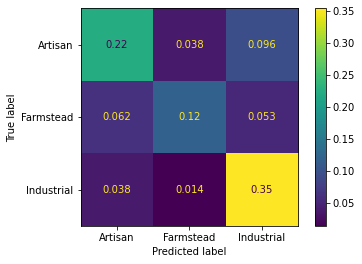

In [16]:
#plot confusion matrix
test_score_plot = plot_confusion_matrix(svc_scores2, X_test, y_test,normalize='all')
test_score_plot

Here is the classification report on our test data

In [17]:
#create y_pred
y_pred = svc_scores2.predict(X_test)
svc_scores2.classes_
#create classification report
print(classification_report(y_test,y_pred, sample_weight=None, digits=2))

              precision    recall  f1-score   support

     Artisan       0.69      0.63      0.66        75
   Farmstead       0.69      0.51      0.59        49
  Industrial       0.70      0.87      0.78        85

    accuracy                           0.70       209
   macro avg       0.70      0.67      0.67       209
weighted avg       0.70      0.70      0.69       209



Now I would like to answer my initial question: is a specific type of milk is more commonly used in artisan cheeses?
We can answer this by plotting milk type vs. artisan cheese

In [18]:
#recombine test set
test_merged = pd.concat([X_test, y_test], axis=1)
test_merged

#create plot of manufacturing type vs. milk type
which_milk_plot = alt.Chart(test_merged, height=300, width=500).mark_bar().encode(
alt.X("ManufacturingTypeEn:N",  title="Manufacturing Type"),
alt.Y('count():Q'),
alt.Color('MilkTreatmentTypeEn')
).properties(title= "Chart 3: Manufacturing Type vs. Milk Treatment Type")
which_milk_plot

alt.Chart(...)

It looks like pasteurized milk is more widely used across all the cheese types.

In [19]:
#clan up
!black Maedeh_Lavvaf_final_project.ipynb

reformatted Maedeh_Lavvaf_final_project.ipynb
All done! ✨ 🍰 ✨
1 file reformatted.


## Discussion

The best model here was our SVC model with hypertuned parameters. It has an f1 score of 66%, and an accuracy score of 70%. The dummy model had an accuracy of 44%, and the hypertuned kNN classifier had an f1 score of 62%. Clearly, the SVC model was the best performing model.
I expected that the SVC model would outperform kNN as we have a smaller dataset. I was initially very surprised when the untuned kNN score was higher than the untuned SVC score.
I think that the score could be further improved with logistic regression and I would be very interested to try out that model on this dataset.


## References

I used reference information from the modules from Programming for Data Science, as well as Introduction to Machine Learning. I referenced assignment 7 when tuning my hyperparameters. I also used the sklearn and altair user guides, as well as google/stack overflow to problem solve.